In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
from concurrent import futures
import threading
from sklearn.model_selection import train_test_split
from collections import Counter

In [0]:
#Load Dataset
# set cell_images folder path for dataset
root ="/content/gdrive/My Drive/Malaria_dataset/cell_images"

# read dataset
base_dir = os.path.join('/content/gdrive/My Drive/Malaria_dataset/cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13794)

In [0]:
#Check top 5 rows of data
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
1,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
2,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
3,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
4,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria


In [0]:
# Partition dataset into training(60),testing(30),validation(10) 
train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17370,) (1931,) (8272,)
Train: Counter({'healthy': 8766, 'malaria': 8604}) 
Val: Counter({'malaria': 979, 'healthy': 952}) 
Test: Counter({'malaria': 4196, 'healthy': 4076})


In [0]:
# Check image Dimensions
def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-3_0: working on img num: 0
ThreadPoolExecutor-3_14: working on img num: 5000
ThreadPoolExecutor-3_4: working on img num: 10000
ThreadPoolExecutor-3_5: working on img num: 15000
ThreadPoolExecutor-3_0: working on img num: 17369
Min Dimensions: [40 46  3]
Avg Dimensions: [133.01278066 132.55129534   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [382 394   3]


In [0]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.bilateralFilter(img, 15, 75, 75) 
    img = cv2.resize(img, dsize=IMG_DIMS, interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape

Loading Train Images:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_10: working on img num: 5000
ThreadPoolExecutor-0_17: working on img num: 10000
ThreadPoolExecutor-0_10: working on img num: 15000
ThreadPoolExecutor-0_17: working on img num: 17369

Loading Validation Images:
ThreadPoolExecutor-0_11: working on img num: 0

Loading Test Images:
ThreadPoolExecutor-0_9: working on img num: 0
ThreadPoolExecutor-0_7: working on img num: 5000
ThreadPoolExecutor-0_9: working on img num: 8271


((17370, 125, 125, 3), (1931, 125, 125, 3), (8272, 125, 125, 3))

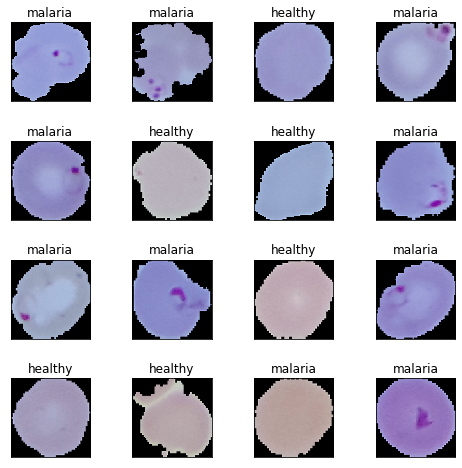

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [0]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.
# encode text category labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

# change version of tensorflow
%tensorflow_version 2.x

print(train_labels[:6], train_labels_enc[:6])

TensorFlow 2.x selected.
['healthy' 'healthy' 'healthy' 'healthy' 'healthy' 'healthy'] [0 0 0 0 0 0]


Labels: ['healthy', 'healthy', 'healthy', 'healthy', 'healthy']


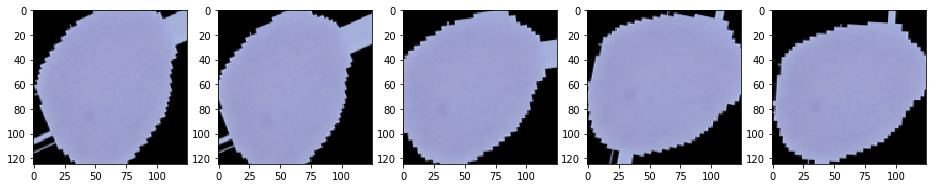

In [0]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

#tf.random.set_random_seed(42)
tf.random.set_seed(42)
tf.__version__

#Applying Data augmentation to images
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# check augmented images
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

# build image augmentation generators
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

Model Training 

In [0]:
#Load pretrained model with imagenet weights
xcept = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
xcept.trainable = False
# Freeze the layers
for layer in xcept.layers:
    layer.trainable = False
xcept.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 62, 62, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 62, 62, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 62, 62, 32)   0           block1_conv1_bn[0][0]            
__________________________

In [0]:
# Tune Model using transfer learning
base_xcept =xcept
base_out = base_xcept.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(2048, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.5)(hidden1)
hidden2 = tf.keras.layers.Dense(2048, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.5)(hidden2)
out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_xcept.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 62, 62, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 62, 62, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 62, 62, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [0]:
#Check how many layers are trainable for model
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 138
Total trainable layers: 6


In [0]:
#train Frozen model
import datetime 
logdir = os.path.join('c:\\Users\\Dell\\Documents\\python_projects', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

Epoch 1/25
271/271 [==============================] - 93s 342ms/step - loss: 0.4317 - accuracy: 0.8617 - val_loss: 0.5935 - val_accuracy: 0.8427
Epoch 2/25
271/271 [==============================] - 88s 326ms/step - loss: 0.3498 - accuracy: 0.8963 - val_loss: 0.8348 - val_accuracy: 0.7375
Epoch 3/25
271/271 [==============================] - 89s 327ms/step - loss: 0.3157 - accuracy: 0.8992 - val_loss: 0.5039 - val_accuracy: 0.8328
Epoch 4/25
271/271 [==============================] - 88s 326ms/step - loss: 0.2808 - accuracy: 0.9089 - val_loss: 0.3934 - val_accuracy: 0.8620
Epoch 5/25
271/271 [==============================] - 88s 325ms/step - loss: 0.2779 - accuracy: 0.9117 - val_loss: 0.3011 - val_accuracy: 0.8839
Epoch 6/25
271/271 [==============================] - 88s 326ms/step - loss: 0.2745 - accuracy: 0.9115 - val_loss: 0.3341 - val_accuracy: 0.8734
Epoch 7/25
271/271 [==============================] - 88s 327ms/step - loss: 0.2589 - accuracy: 0.9137 - val_loss: 1.2384 - val_ac

In [0]:
#plot accuracy and loss of trained model on training and validation data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Xception frozen model with bilateral', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['acc'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('xception_frozen_bilateral.h5')

**Xception** Model finetuning

In [0]:
#Finetuning of model
Xcept = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
Xcept.trainable = False

set_trainable = False
for layer in Xcept.layers:
    if layer.name in ['']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_Xcept = Xcept
base_out = base_Xcept.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(1024, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(1024, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_Xcept.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 131, 131, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 63, 63, 64)   9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 63, 63, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [0]:
#train finetuned model
import datetime 
logdir = os.path.join('c:\\Users\\Dell\\Documents\\python_projects', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

In [0]:
#plot accuracy and loss of trained model on training and validation data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Xception finetuned model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('Xception_finetuned.h5')

In [0]:
#scale test data
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((8272, 125, 125, 3), (8272,))

In [0]:
# Load Saved Deep Learning Models
xception_frz = tf.keras.models.load_model('/content/xception_frozen_bilateral.h5')
xception_ft = tf.keras.models.load_model('/content/Xception_finetuned.h5')

# Make Predictions on Test Data
xception_frz_preds = xception_frz.predict(test_imgs_scaled, batch_size=512)
xceptiont_ft_preds = xception_ft.predict(test_imgs_scaled, batch_size=512)

xception_frz_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in xception_frz_preds.ravel()])
xception_ft_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in xception_ft_preds.ravel()])

In [0]:
#upload model evaluation file named as model_evaluation_utils
from google.colab import files 
uploaded = files.upload()

Saving model_evaluation_utils.py to model_evaluation_utils.py


In [ ]:
import model_evaluation_utils as meu
import pandas as pd

xception_frz_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=xception_frz_pred_labels)
xception_ft_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=xception_ft_pred_labels)

pd.DataFrame([xception_frz_metrics , xception_ft_metrics ], 
             index=['Xception Frozen','Xception Finetuned' ])